# The Relation Between Runs and Wins

In [105]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting_utils import plot_regression

sns.set_theme(style='darkgrid', palette='deep')

## Load Data

Teams win by outscoring opponents. Exploring this relationship using MLB data from 2001-2024.

Data source: [Lahman Baseball Database](https://sabr.org/lahman-database/)

In [106]:
teams = pd.read_csv('../data/lahman/Teams.csv')

## 4.2 The Teams Table in the Lahman Database

The Lahman database contains team statistics dating back to 1871. This notebook 
focuses on seasons from 2001-2024 to analyze modern baseball. The covid 2020 shortened season was not included as only 60 games were played.

Key variables:
- `W`, `L` - Wins and losses
- `R`, `RA` - Runs scored and runs allowed
- `G` - Games played

In [107]:
teams.tail(3)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
3581,2024,AL,TEX,TEX,W,3,162,81.0,78,84,...,106.0,0.987,Texas Rangers,Globe Life Field,2651553.0,96.0,96.0,TEX,TEX,TEX
3582,2024,AL,TOR,TOR,E,5,162,81.0,74,88,...,125.0,0.984,Toronto Blue Jays,Rogers Centre,2681236.0,103.0,103.0,TOR,TOR,TOR
3583,2024,NL,WAS,WSN,E,4,162,81.0,71,91,...,155.0,0.981,Washington Nationals,Nationals Park,1967302.0,96.0,98.0,WSN,MON,WAS


Filter to recent seasons and extract key variables:
- **R**: Runs scored
- **RA**: Runs allowed
- **W/L**: Wins and losses

In [ ]:
my_teams = teams.loc[(teams['yearID'] > 2000) & (teams['yearID'] != 2020),
                      ['teamID', 'name', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA']]
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0


### Creating Key Metrics

**Run Differential (RD)**: The difference between runs scored and runs allowed. 
Teams that outscore opponents have positive run differentials.

**Winning Percentage (Wpct)**: Fraction of games won. In a 162-game season, 
a .500 team wins 81 games.

In [109]:
my_teams['RD'] = my_teams['R'] - my_teams['RA']
my_teams['Wpct'] = my_teams['W'] / (my_teams['W'] + my_teams['L'])
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA,RD,Wpct
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0,-39.0,0.462963
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0,141.0,0.567901
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0,86.0,0.543210
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0,-142.0,0.391304
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0,27.0,0.509317


## 4.3 Linear Regression

$$Wpct = a + b \times RD + \epsilon$$


Plot relationship between **Run Differential (RD)** and **Winning Percentage (Wpct)** for 2001-2024 seasons

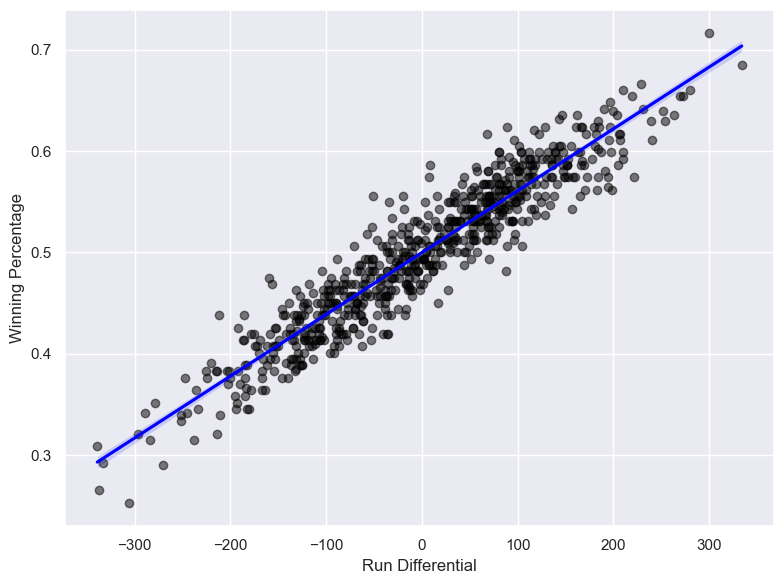

In [110]:
plot_regression(data=my_teams, x='RD', y='Wpct', xlabel='Run Differential', ylabel='Winning Percentage')
plt.show()

In [111]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit linear regression model
X = my_teams[['RD']].values
y = my_teams['Wpct'].values

linfit = LinearRegression()
linfit.fit(X, y)

# Display coefficients
intercept = linfit.intercept_
slope = linfit.coef_[0]

print(f"Intercept (a): {intercept:.6f}")
print(f"Slope (b): {slope:.6f}")
print(f"Equation: Wpct = {intercept:.6f} + {slope:.6f} * RD")

Intercept (a): 0.499991
Slope (b): 0.000610
Equation: Wpct = 0.499991 + 0.000610 * RD


### Interpreting the Linear Model

The model estimates:
- **Intercept ≈ 0.500**: A team with RD=0 is expected to win half its games
- **Slope ≈ 0.000610**: Each additional run of differential increases winning 
  percentage by 0.000610

**Practical interpretation**: In a 162-game season, a 10-run improvement in 
run differential corresponds to approximately one additional win 
(0.000610 × 10 × 162 ≈ 1 win).

In [112]:
from sklearn.metrics import root_mean_squared_error

# Calculate predictions and residuals
my_teams['predicted_Wpct'] = linfit.predict(X)
my_teams['residuals'] = my_teams['Wpct'] - my_teams['predicted_Wpct']

# Calculate R-squared
r_squared = linfit.score(X, y)
print(f"R-squared: {r_squared:.4f}")

# Calculate RMSE (Root Mean Square Error)
rmse = root_mean_squared_error(y, my_teams['predicted_Wpct'])
print(f"RMSE: {rmse:.4f}")
print(f"This means predictions are accurate within about {rmse*100:.1f} percentage points")

R-squared: 0.8885
RMSE: 0.0251
This means predictions are accurate within about 2.5 percentage points


### Understanding Residuals

**Residuals** measure prediction error which is the difference between actual and 
predicted winning percentage. Large positive residuals indicate teams that 
won more than expected and large negative residuals indicate underperformers.

We calculate RMSE (Root Mean Square Error) to measure average prediction error.

In [113]:
# View some examples with predictions and residuals
my_teams[['name', 'yearID', 'W', 'L', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']].sample(10)

,name,yearID,W,L,RD,Wpct,predicted_Wpct,residuals
3388,Miami Marlins,2018,63,98,-220.0,0.391304,0.365813,0.025491
3032,New York Mets,2006,97,65,103.0,0.598765,0.562811,0.035954
3383,Detroit Tigers,2018,64,98,-166.0,0.395062,0.398748,-0.003686
3211,New York Yankees,2012,95,67,136.0,0.586420,0.582938,0.003482
3326,Los Angeles Angels of Anaheim,2016,74,88,-10.0,0.456790,0.493892,-0.037102
3428,San Francisco Giants,2019,77,85,-95.0,0.475309,0.442051,0.033258
3123,Oakland Athletics,2009,75,87,-2.0,0.462963,0.498772,-0.035809
3269,Milwaukee Brewers,2014,82,80,-7.0,0.506173,0.495722,0.010451
3271,New York Yankees,2014,84,78,-31.0,0.518519,0.481084,0.037434
3051,Cleveland Indians,2007,96,66,107.0,0.592593,0.565251,0.027342


### Residual Plot

Figure 4.2 displays a plot of the residuals against the run differential. We'll highlight the 6 teams with the largest residuals.

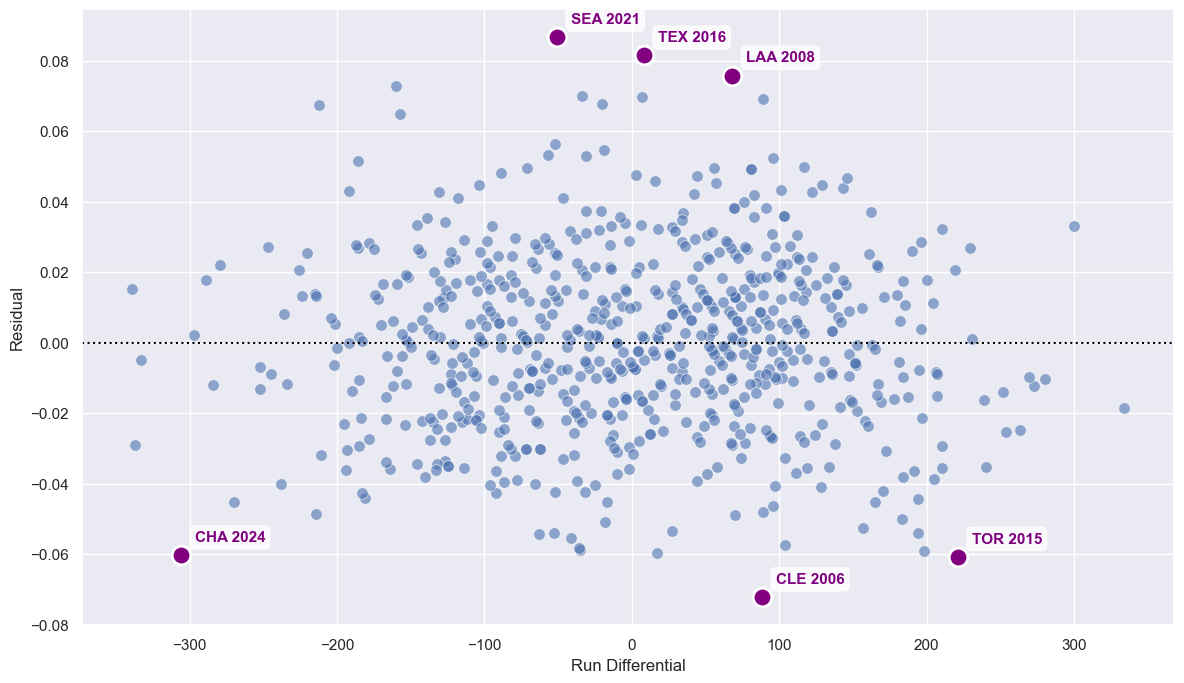

In [114]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=my_teams, x='RD', y='residuals', alpha=0.6, s=70, ax=ax)
ax.axhline(y=0, linestyle=':', color='black', linewidth=1.5)
ax.set_xlabel('Run Differential', fontsize=12)
ax.set_ylabel('Residual', fontsize=12)

# Find 3 highest residuals and 3 lowest residual
top_3 = my_teams.nlargest(3, 'residuals')
bottom_3 = my_teams.nsmallest(3, 'residuals')
outlier_teams = pd.concat([top_3, bottom_3])

# Highlight and label these teams
for _, row in outlier_teams.iterrows():
    ax.scatter(row['RD'], row['residuals'], color='purple', s=180, zorder=5, edgecolors='white', linewidth=2)
    ax.annotate(f"{row['teamID']} {int(row['yearID'])}", 
               xy=(row['RD'], row['residuals']),
               xytext=(10, 10), 
               textcoords='offset points',
               color='purple', 
               fontsize=11,
               fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [115]:
outlier_teams[['teamID', 'name', 'yearID', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']]

,teamID,name,yearID,RD,Wpct,predicted_Wpct,residuals
3487,SEA,Seattle Mariners,2021,-51.0,0.555556,0.468886,0.086669
3341,TEX,Texas Rangers,2016,8.0,0.586420,0.504871,0.081549
3087,LAA,Los Angeles Angels of Anaheim,2008,68.0,0.617284,0.541465,0.075819
3021,CLE,Cleveland Indians,2006,88.0,0.481481,0.553663,-0.072181
3312,TOR,Toronto Blue Jays,2015,221.0,0.574074,0.634780,-0.060706
3558,CHA,Chicago White Sox,2024,-306.0,0.253086,0.313361,-0.060275


Residuals show how far each team's actual winning percentage differs from the model's prediction. Teams furthest from the zero line had the biggest prediction errors.


## 4.4 The Pythagorean Formula for Winning Percentage

Bill James developed the Pythagorean expectation to estimate winning percentage using runs scored and runs allowed. Unlike the linear model, this formula provides a ratio-based approach.

$$\widehat{Wpct} = \frac{R^2}{R^2 + RA^2}$$

In [116]:
#create Wpct_pt column to the my_teams dataframe
my_teams['Wpct_pyt'] = my_teams['R'] ** 2 / (my_teams['R'] ** 2 + my_teams['RA'] ** 2)

#create residuals_pyt column to my_teams dataframe for difference between actual and predicted winning percentages
my_teams['residuals_pyt'] = my_teams['Wpct'] - my_teams['Wpct_pyt']

In [117]:
# Calculate RMSE for Pythagorean predictions
rmse_pyt = np.sqrt((my_teams['residuals_pyt'] ** 2).mean())
print(f"RMSE (Pythagorean): {rmse_pyt:.4f}")

RMSE (Pythagorean): 0.0261


#### Comparing the Models

The Pythagorean formula is slightly less accurate (RMSE: 0.0261 vs 0.0251), but it has a key advantage: it always produces valid winning percentages between 0 and 1.

The linear model can predict winning percentages above 1.0 or below 0 for extreme teams, which is impossible. This matters for:
- Historically dominant or terrible teams (2001 Mariners, 2024 White Sox, etc.)
- Hypothetical scenarios when evaluating player value

For most teams the models perform similarly, but the Pythagorean formula does a better job at handling extreme outlier cases


### 4.4.1 The Exponent in the Pythagorean model

#### Finding the Optimal Exponent

The original Pythagorean formula uses an exponent of 2, but we can find a better fitting exponent. Starting with the general form with exponent k:

$$\widehat{Wpct} = \frac{R^k}{R^k + RA^k}$$

This can be rewritten as a ratio of wins to losses:

$$\frac{W}{L} \approx \frac{R^k}{RA^k}$$

Taking logarithms of both sides gives us a linear relationship:

$$\log\left(\frac{W}{L}\right) \approx k \cdot \log\left(\frac{R}{RA}\right)$$

We can estimate k using linear regression through the origin, where the response is log(W/L) and the predictor is log(R/RA).


In [118]:
# Calculate log ratios for linear regression
my_teams['logWratio'] = np.log(my_teams['W']/my_teams['L'])
my_teams['logRratio'] = np.log(my_teams['R']/my_teams['RA'])

In [119]:
# Fit linear regression through origin to find optimal exponent
X_log = my_teams[['logRratio']].values
y_log = my_teams['logWratio'].values

# fit_intercept=False forces regression through origin
pytFit = LinearRegression(fit_intercept=False)
pytFit.fit(X_log, y_log)

k = pytFit.coef_[0]
print(f"Optimal exponent (k): {k:.2f}")

Optimal exponent (k): 1.82


The regression suggests an optimal Pythagorean exponent of **1.82**, which is smaller than the originally proposed value of 2.

### 4.4.2 Good and bad predictions by the Pythagorean model

Using specific team examples to understand when the Pythagorean formula works well and when it does not.

**2011 Boston Red Sox**: Scored 875 runs, allowed 737
- Pythagorean prediction (k=2): ≈ 95 wins
- Actual wins: 90
- Miss by 5 games - costly, as the Red Sox missed the Wild Card

**2011 Tampa Bay Rays**: Scored 707 runs, allowed 614
- Pythagorean prediction: ≈ 92 wins  
- Actual wins: 91
- Miss by 1 game - more accurate prediction
- Won the AL Wild Card on the last game of the season over the Red Sox

Why did the formula miss so badly on the Red Sox?

In [120]:
# Load column names
column_names = pd.read_csv('../data/game_log_header.csv').columns.tolist()

# Load 2011 game log data
gl2011 = pd.read_csv('../data/gl2011.txt', header=None, names=column_names)

# Filter for just Red Sox games
BOS2011 = gl2011[(gl2011['HomeTeam'] == 'BOS') | (gl2011['VisitingTeam'] == 'BOS')].copy()

# Select relevant columns
BOS2011 = BOS2011[['VisitingTeam', 'HomeTeam', 'VisitorRunsScored', 'HomeRunsScore']]

BOS2011.head(6)


,VisitingTeam,HomeTeam,VisitorRunsScored,HomeRunsScore
15,BOS,TEX,5,9
30,BOS,TEX,5,12
44,BOS,TEX,1,5
60,BOS,CLE,1,3
75,BOS,CLE,4,8
87,BOS,CLE,0,1


In [121]:
#calculate run differentials, games won and lost for Red Sox
BOS2011['ScoreDiff'] = BOS2011.apply(
    lambda x: x['HomeRunsScore'] - x['VisitorRunsScored'] if x['HomeTeam'] == 'BOS' else x['VisitorRunsScored'] - x['HomeRunsScore'],
    axis=1
)

BOS2011['W'] = BOS2011['ScoreDiff'] > 0

In [122]:
# Group by win/loss and calculate summary statistics
BOS2011.groupby('W')['ScoreDiff'].describe()

,count,mean,std,min,25%,50%,75%,max
W,,,,,,,,
False,72.0,-3.458333,2.556062,-11.0,-4.0,-3.0,-1.0,-1.0
True,90.0,4.300000,3.282401,1.0,2.0,4.0,6.0,14.0


The 2011 Red Sox won their games by larger margins than they lost them (4.3 vs -3.5 runs on average). This uneven distribution of runs explains why they underperformed their Pythagorean prediction by 5 games.

Teams that significantly over or underperform their Pythagorean expectation are often considered "lucky" or "unlucky" and the expectation is they will regress toward their predicted winning percentage as the season progresses.


In [123]:
results = gl2011[['VisitingTeam', 'HomeTeam', 'VisitorRunsScored', 'HomeRunsScore']].copy()

In [124]:
# Determine winner and margin of victory for each game
results['winner'] = results.apply(
    lambda x: x['HomeTeam'] if x['HomeRunsScore'] > x['VisitorRunsScored'] else x['VisitingTeam'],
    axis=1
)

results['diff'] = abs(results['VisitorRunsScored'] - results['HomeRunsScore'])

In [ ]:
# Count one run wins by team (games decided by exactly 1 run)
one_run_wins = results[results['diff'] == 1].groupby('winner').size().reset_index(name='one_run_w')

In [126]:
# Filter for 2011 season and fix team abbreviation for LA Angels
teams2011 = my_teams[my_teams['yearID'] == 2011].copy()
teams2011['teamID'] = teams2011['teamID'].replace('LAA', 'ANA')

# Merge with one_run_wins
teams2011 = teams2011.merge(one_run_wins, left_on='teamID', right_on='winner')

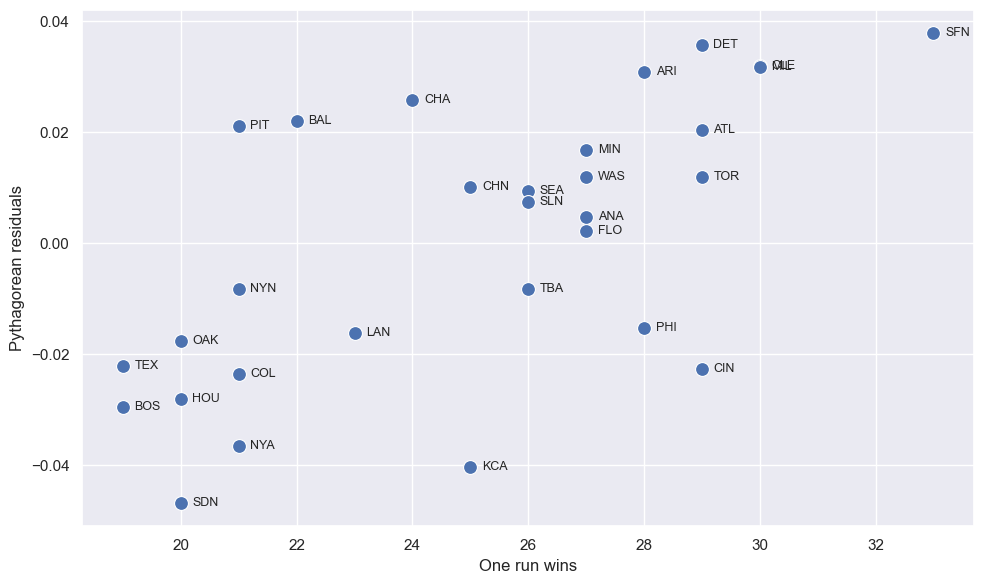

In [127]:
# Plot relationship between one run wins and Pythagorean residuals
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=teams2011, x='one_run_w', y='residuals_pyt', s=100, ax=ax)

# Add team labels to plot
for _, row in teams2011.iterrows():
    ax.text(row['one_run_w'] + 0.2, row['residuals_pyt'], row['teamID'], 
            fontsize=9, ha='left', va='center')

ax.set_xlabel('One run wins', fontsize=12)
ax.set_ylabel('Pythagorean residuals', fontsize=12)
plt.tight_layout()
plt.show()

#### Interpreting the Results

The plot shows a positive relationship with teams winning more one-run games (San Francisco with 33) tend to have positive Pythagorean residuals, while teams with fewer one-run wins (San Diego with 20) have negative residuals.

#### Can teams with top closers outperform their Pythagorean expected winning percentage?

In [ ]:
# Load pitching data to identify elite closers
pitching = pd.read_csv('../data/pitching.csv')

In [129]:
top_closers = pitching.loc[(pitching['GF'] > 50) & (pitching['ERA'] < 2.5), ['playerID', 'yearID', 'teamID']]

In [ ]:
# Merge teams with top closers and examine Pythagorean residuals
my_teams.merge(top_closers)['residuals_pyt'].describe()

count    70.000000
mean      0.005189
std       0.025196
min      -0.048693
25%      -0.011658
50%       0.003359
75%       0.022993
max       0.071399
Name: residuals_pyt, dtype: float64

The mean Pythagorean residual for teams with top closers is 0.005. Multiplied by 162 games, teams with elite closers win approximately 0.8 additional games beyond their Pythagorean prediction, suggesting that strong closers provide a measurable advantage in close games.

### 4.5 How Many Runs for a Win?

A common sabermetrics rule of thumb: ten runs equal one win over the course of a 162-game season.

This rule comes directly from the Pythagorean model. Consider a team scoring and allowing 5 runs per game (810 runs over 162 games):
- At 810 R and 810 RA: Pythagorean expectation = .500 (81 wins)
- At 820 R and 810 RA: Pythagorean expectation = .506 (82 wins)

The 10-run difference produces 1 additional win.

#### Deriving Runs per Win Calculation

Ralph Caola (2003) derived this relationship rigorously using calculus. Starting from the Pythagorean formula for wins:

$$W = G \cdot \frac{R^2}{R^2 + RA^2}$$

By taking the derivative of this formula with respect to runs scored (R), we can calculate how many runs are needed to produce one additional win.


Python can calculate derivatives using the SymPy library. The derivative formula simplifies to:

$$IR/W = \frac{(R^2 + RA^2)^2}{2 \cdot G \cdot R \cdot RA^2}$$


In [137]:
def IR(RS=5, RA=5):
    """
    Calculate incremental runs per win.
    RS: Runs scored per game
    RA: Runs allowed per game
    """
    return (RS**2 + RA**2)**2 / (2 * RS * RA**2)

In [141]:
# Create all combinations of RS and RA values from 3 to 6 in 0.5 increments
RS_values = np.arange(3, 6.5, 0.5)
RA_values = np.arange(3, 6.5, 0.5)

# Create all combinations in a dataframe
ir_table = pd.DataFrame([(rs, ra) for rs in RS_values for ra in RA_values], 
                        columns=['RS', 'RA'])

In [142]:
ir_table.head(4)

,RS,RA
0,3.0,3.0
1,3.0,3.5
2,3.0,4.0
3,3.0,4.5


In [143]:
ir_table.tail(4)

,RS,RA
45,6.0,4.5
46,6.0,5.0
47,6.0,5.5
48,6.0,6.0


In [140]:
# Calculate incremental runs for all RS/RA combinations
ir_table['IRW'] = ir_table.apply(lambda x: IR(x['RS'], x['RA']), axis=1)

# Pivot to wide format and round to 1 decimal
ir_pivot = ir_table.pivot(index='RS', columns='RA', values='IRW')
ir_pivot.columns = [f'RA={col}' for col in ir_pivot.columns]
ir_pivot.round(1)

,RA=3.0,RA=3.5,RA=4.0,RA=4.5,RA=5.0,RA=5.5,RA=6.0
RS,,,,,,,
3.0,6.0,6.1,6.5,7.0,7.7,8.5,9.4
3.5,7.2,7.0,7.1,7.5,7.9,8.5,9.2
4.0,8.7,8.1,8.0,8.1,8.4,8.8,9.4
4.5,10.6,9.6,9.1,9.0,9.1,9.4,9.8
5.0,12.8,11.3,10.5,10.1,10.0,10.1,10.3
5.5,15.6,13.4,12.2,11.4,11.1,11.0,11.1
6.0,18.8,15.8,14.1,13.0,12.4,12.1,12.0


The ten runs per win rule applies to typical scoring environments (4-5 runs per game). In low scoring games fewer runs are needed for a win and in high scoring games more runs are required.